In [11]:
%matplotlib inline

This is a probram to see the raw data before **esoreflex** reduction.

### Goal

Identify problems in the data before basic reduction

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from astropy.io import fits as py

plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['font.size'] = 25

Modify this path to where is the data:

In [ ]:
raw_data_path = "/Users/ricardoramirez/Downloads/archive/"

Cheking the folder:

In [17]:
# Check if the path exists
if os.path.exists(raw_data_path):
    print(f"The path {raw_data_path} exists.")
else:
    print(f"The path {raw_data_path} does not exist.")

# Get list of all files and directories
all_files_and_dirs = os.listdir(raw_data_path)

# Filter only files (exclude directories)
only_files = [f for f in all_files_and_dirs if os.path.isfile(os.path.join(raw_data_path, f))]

if len(only_files) > 0:
    print("There is at least one file in the directory.")
else:
    print("The directory is empty.")

# Filter only FITS files
fits_files = [f for f in only_files if f.endswith('.fits')]

# Print list of FITS files
# print("List of FITS files:", fits_files)

The path /Users/ricardoramirez/Downloads/archive/ exists.
There is at least one file in the directory.


Identify kind of objets that are present:

In [25]:
# Initialize a dictionary to store counts of each object type
object_counts = defaultdict(int)

# Initialize a dictionary to store lists of FITS files for each object type
object_files = defaultdict(list)

for fits_file in fits_files:
    # Complete file path
    full_path = os.path.join(raw_data_path, fits_file)
    
    # Open the FITS file and read its header
    with py.open(full_path) as hdul:
        header = hdul[0].header
        
        # Check if 'OBJECT' exists in header
        if 'OBJECT' in header:
            object_type = header['OBJECT']
            
            # Update the count and list for this object type
            object_counts[object_type] += 1
            object_files[object_type].append(fits_file)

# Print the counts and lists for each object type
print("Counts of each object type:")
for object_type, count in object_counts.items():
    print(f"{object_type}: {count}")

#print("\nFITS files for each object type:")
#for object_type, files in object_files.items():
#    print(f"{object_type}: {files}")

Counts of each object type:
LAMP,METROLOGY: 12
HD 201585: 107
DARK: 9
WAVE,UNE: 1
FLAT: 3
WAVE,FPET: 1
OBJECT: 1


In [30]:
# Initialize a dictionary to store metadata for each object type
object_metadata = defaultdict(lambda: defaultdict(set))
# Initialize a dictionary to store the minimum and maximum dates for each object type
object_date_ranges = defaultdict(lambda: {'min_date': datetime.max, 'max_date': datetime.min})

# Check if the path exists
if os.path.exists(raw_data_path):
    # Get list of all files and directories
    all_files_and_dirs = os.listdir(raw_data_path)
    
    # Filter only files (exclude directories)
    only_files = [f for f in all_files_and_dirs if os.path.isfile(os.path.join(raw_data_path, f))]
    
    # Filter only FITS files
    fits_files = [f for f in only_files if f.endswith('.fits')]
    
    for fits_file in fits_files:
        # Complete file path
        full_path = os.path.join(raw_data_path, fits_file)

        # Open the FITS file and read its header
        with py.open(full_path) as hdul:
            header = hdul[0].header
            
            # Check if 'OBJECT' exists in header
            if 'OBJECT' in header:
                object_type = header['OBJECT']
                
                # Add the metadata fields
                for field in ['ORIGIN', 'TELESCOP', 'INSTRUME', 'EXPTIME']:
                    if field in header:
                        object_metadata[object_type][field].add(header[field])
                
                obs_date_str = header['DATE-OBS']
                
                # Convert the date string to a datetime object for comparison
                obs_date = datetime.strptime(obs_date_str, '%Y-%m-%dT%H:%M:%S.%f')
                
                # Update the min and max dates for this object type
                object_date_ranges[object_type]['min_date'] = min(object_date_ranges[object_type]['min_date'], obs_date)
                object_date_ranges[object_type]['max_date'] = max(object_date_ranges[object_type]['max_date'], obs_date)

# Print the range of dates for each object type
print("Range of dates for each object type:")
for object_type, date_range in object_date_ranges.items():
    print(f"{object_type}: from {date_range['min_date']} to {date_range['max_date']}")

print("\nMetadata for each object type:")
for object_type, metadata in object_metadata.items():
    print(f"\nObject Type: {object_type}")
    for field, values in metadata.items():
        if len(values) == 1:
            print(f"{field}: {list(values)[0]}")
        else:
            print(f"{field}: Multiple values found")

Range of dates for each object type:
LAMP,METROLOGY: from 2021-09-17 00:44:37.245600 to 2021-09-17 05:17:11.655800
HD 201585: from 2021-09-17 00:50:28.255600 to 2021-09-17 05:34:01.345900
DARK: from 2021-09-17 11:36:03.998000 to 2021-09-17 11:57:21.812600
WAVE,UNE: from 2021-09-17 11:30:11.502800 to 2021-09-17 11:30:11.502800
FLAT: from 2021-09-17 11:27:38.551800 to 2021-09-17 11:27:57.873400
WAVE,FPET: from 2021-09-17 11:31:08.290200 to 2021-09-17 11:31:08.290200
OBJECT: from 2021-09-17 00:50:15.659800 to 2021-09-17 00:50:15.659800

Metadata for each object type:

Object Type: LAMP,METROLOGY
ORIGIN: ESO-PARANAL
TELESCOP: ESO-VLT-U3
INSTRUME: CRIRES
EXPTIME: 2.0

Object Type: HD 201585
ORIGIN: ESO-PARANAL
TELESCOP: ESO-VLT-U3
INSTRUME: CRIRES
EXPTIME: 30.0

Object Type: DARK
ORIGIN: ESO-PARANAL
TELESCOP: ESO-VLT-U3
INSTRUME: CRIRES
EXPTIME: Multiple values found

Object Type: WAVE,UNE
ORIGIN: ESO-PARANAL
TELESCOP: ESO-VLT-U3
INSTRUME: CRIRES
EXPTIME: 10.0

Object Type: FLAT
ORIGIN: ESO

# Function to plot the fits

In [35]:
# Function to plot the data for selected object types
def plot_data_for_object_types(selected_types=None, selected_indices=None):
    # If no types are specified, plot for all
    if selected_types is None:
        selected_types = object_files.keys()
    
    for object_type in selected_types:
        if object_type not in object_files:
            print(f"No data found for object type {object_type}")
            continue
        
        print(f"Plotting for object type: {object_type}")
        
        # Select indices to plot
        if selected_indices is None:
            indices_to_plot = range(len(object_files[object_type]))
        else:
            indices_to_plot = selected_indices
        
        for index in indices_to_plot:
            fits_file = object_files[object_type][index]
            
            # Complete file path
            full_path = os.path.join(raw_data_path, fits_file)
            
            # Open the FITS file and read its data
            with py.open(full_path) as hdul:
                raw_data = hdul[1].data
                
                # Create the plot
                plt.figure()
                plt.title(f"Object: {object_type}, File: {fits_file}")
                plt.imshow(raw_data, vmax=1200, vmin=100)
                plt.colorbar()
                plt.show()

# Call the function to plot for all object types
# plot_data_for_object_types()

# Or specify which types you want to plot for
# plot_data_for_object_types(['Type1', 'Type2'])


Plotting for object type: DARK


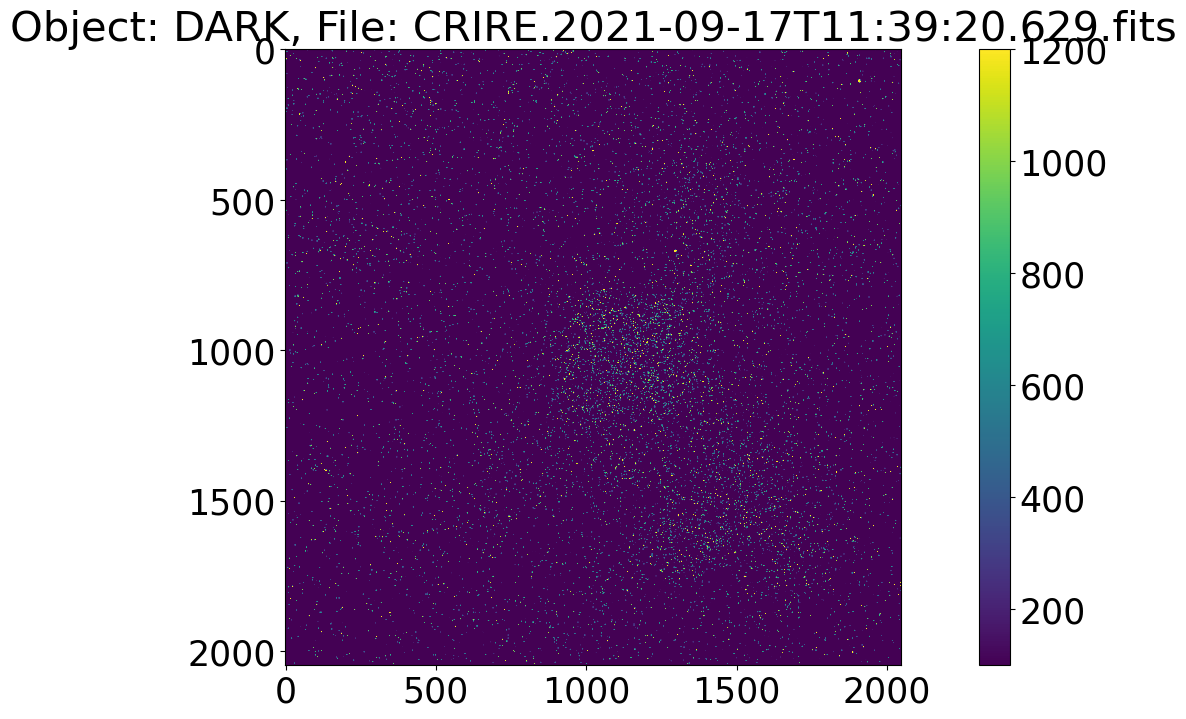

In [40]:
# plot all Dark
# plot_data_for_object_types(selected_types=['DARK'])
# plot one Dark
plot_data_for_object_types(selected_types=['DARK'], selected_indices=(0,))

[[ 3.3099937e+03  3.3400410e+03  3.1137676e+03 ...  3.4224758e+03
   3.3812180e+03  3.6237891e+03]
 [ 5.4116205e+02  5.5513995e+02  5.1730908e+02 ...  5.6223560e+02
   5.6085059e+02  6.0189484e+02]
 [ 1.0749249e+02  1.1129881e+02  1.0716048e+02 ...  1.1693121e+02
   1.1637866e+02  1.2189723e+02]
 ...
 [-1.5865614e+00 -2.4332016e+00 -1.5889330e+00 ... -2.6039526e+00
  -2.8079052e+00 -1.4822135e+00]
 [ 2.6324099e-01  1.2592885e+00 -2.1770749e+00 ... -2.9786563e+00
  -4.7312255e+00  5.2173913e-01]
 [-2.5849800e+00  1.8118576e+00  2.3430829e+00 ... -1.4371541e+00
  -1.2213438e+00 -5.5256920e+00]]


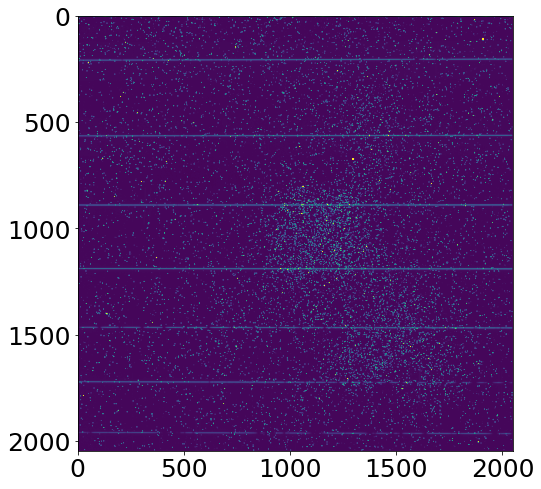

In [40]:
#plt.imshow(surface,  interpolation='none', cmap='bwr', vmax=10000 ,vmin=-10000)
file_selected = 20
print(raw_data_list[file_selected])
plt.imshow(raw_data_list[file_selected], vmax=1200 ,vmin=-20)

In [52]:
data = np.zeros((2000,2000))
data = raw_data_list[file_selected]
index = np.where(data > 2000)
data[index] = 0

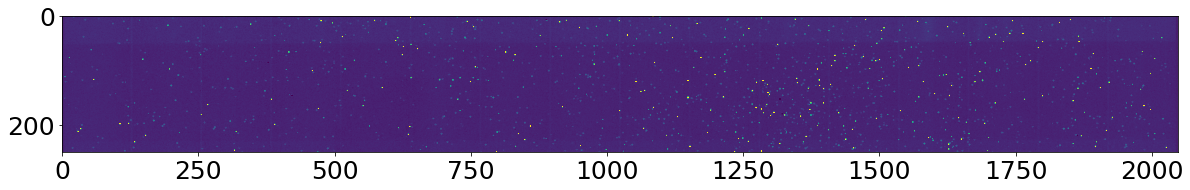

In [53]:
plt.imshow(data[250:500], vmax=200 ,vmin=-20)

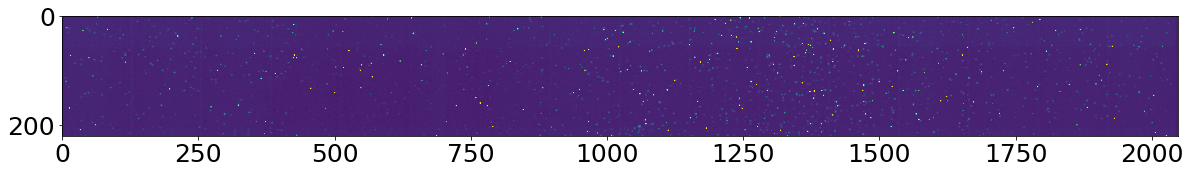

In [54]:
plt.imshow(data[600:820], vmax=200 ,vmin=-20)

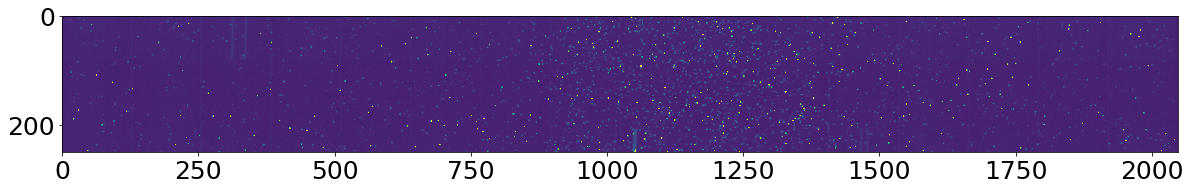

In [55]:
plt.imshow(data[900:1150], vmax=200 ,vmin=-20)

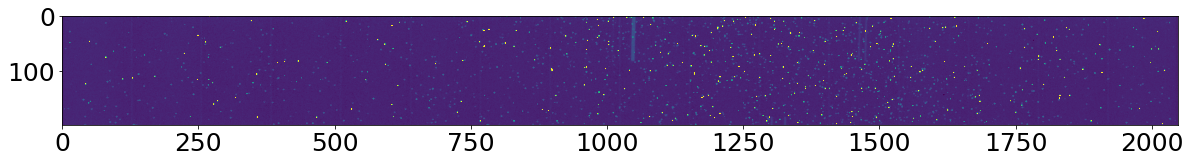

In [56]:
plt.imshow(data[1200:1400], vmax=200 ,vmin=-20)

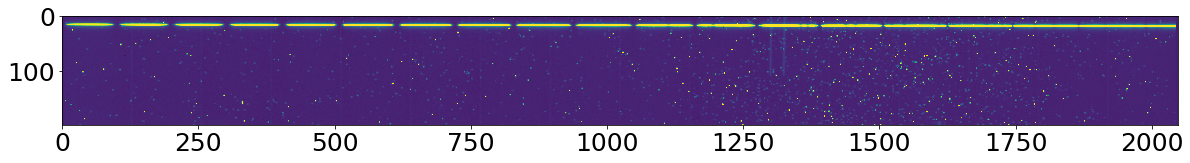

In [57]:
plt.imshow(data[1450:1650], vmax=200 ,vmin=-20)

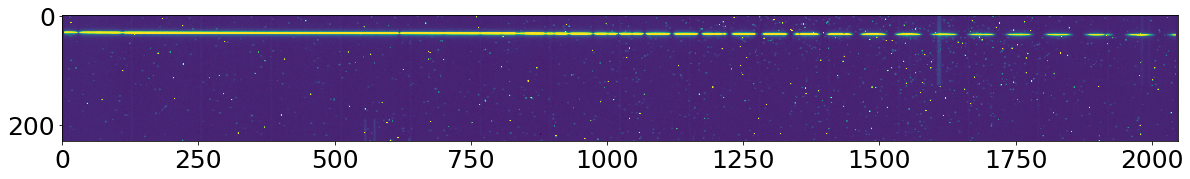

In [58]:
plt.imshow(data[1690:1920], vmax=200 ,vmin=-20)

(-20.0, 1250.0)

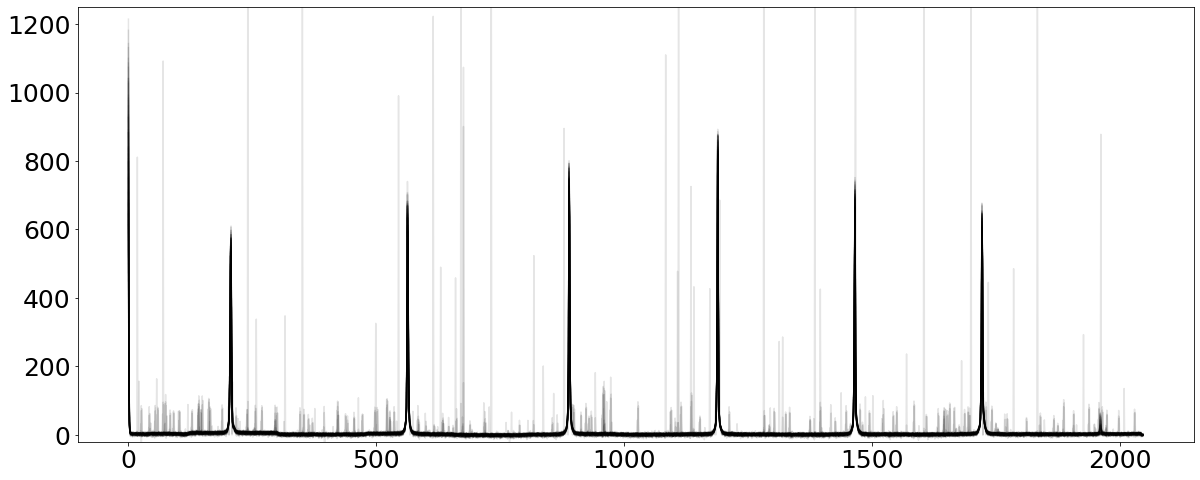

In [59]:
for i in range(50):
    plt.plot(data[:,420+i], alpha = 0.1, color = 'k')  
plt.ylim(-20,1250)
#plt.xlim(0,800)

(-20.0, 1200.0)

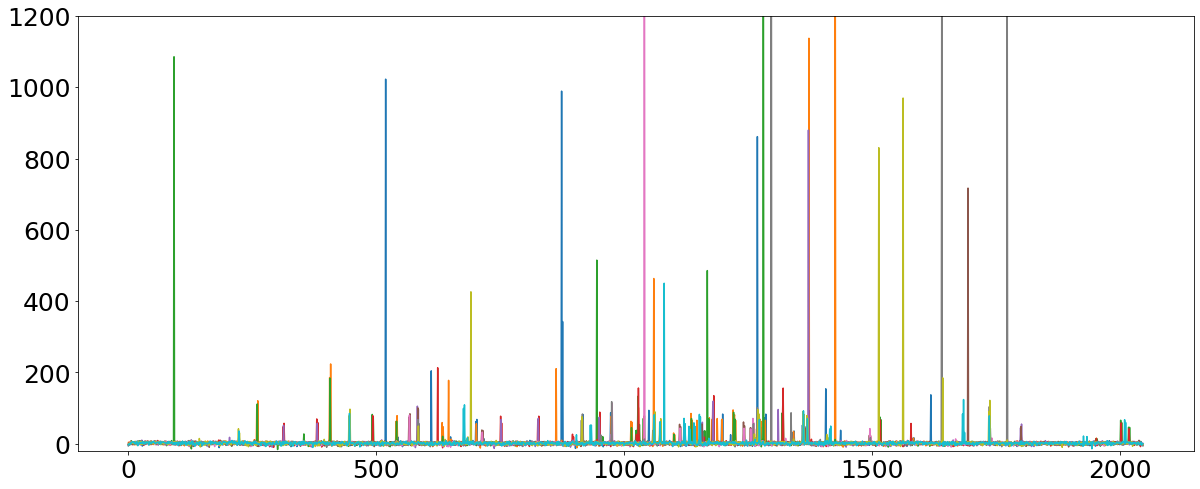

In [60]:
for i in range(10):
    plt.plot(data[1020+i])  
plt.ylim(-20,1200)